Here we will analyse the relationship between GDP per capita and life expectancy. 
Data from International Monetary Fund and World Health Organisation.

In [1]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
def column(n, list):
    try:
        return list[n]
    except:
        return "Error"
    
def gdpc(country):
    """Return GDP per capita for a given country"""
    for row in csv.reader(open('gdpcapita.csv'),delimiter='\t'):
        if row[0]==country:
            return row[4]
        
def lfexp(country):
    """Return life expectancy for a given country"""
    for row in csv.reader(open('life_expectancy.csv')):
        if row[0]==country:
            return row[1]

Get countries in datasets. If there's a country which is not in both sets, eliminate it.

In [3]:
#get data in gdp dataset
countries = set()
with open('gdpcapita.csv') as data:
    info = csv.reader(data,delimiter='\t')
    for row in info:
        countries.add(column(0,row))
    
#Eliminate the header from the set

to_del = ['Country','Subject','Descriptor','Units','Scale','2015','Estimates', 'Start',
          'After', 'International Monetary Fund, World Economic Outlook Database, April 2016']
for element in to_del:
    countries.discard(element)

In [4]:
#get countries in life expectancy dataset
countries2 = set()
with open('life_expectancy.csv',encoding='utf-8') as data:
    info = csv.reader(data)
    for row in info:
        countries2.add(row[0])
#Here we haven't deleted the headers, but the next step will do so automatically

In [5]:
# Find countries in both datasets, and deletes all others
countries = countries & countries2

#Print data. Now that we have it clean, we may as well enjoy it :)
##for country in countries:
##    print('{} GDP: {}. life expectancy:{}'.format(country, gdpc(country), lfexp(country)))

In [6]:
# Creates list with all the data for each country, as a list of lists, in format 
#[[gdp per capita1,life expectancy1]...]. We don't need to know what country it is for this.

data = []
for country in countries:
    temp = []
    temp.extend([gdpc(country),lfexp(country)])
    data.append(temp)
    del temp

The folowwing cell sets the x_values to the GDP per capita, and the y_values to the life expectancy of the country.

In [7]:
# x axis: gdp/capita
# y axis: life expectancy
x_values = []
y_values = []
for country in data:
    x_values.append(country[0])
    y_values.append(country[1])

In [8]:
#Remove empty data
for i in range(len(y_values)-1):
    if y_values[i] == None:
        del y_values[i]
        del x_values[i]
        
#iterate over all numbers, and over all digits in it (as of now, treated as string). Converts it string -> float. 
#This is just to delete the ',' separating digits.   It's probably very inefficient

for i in range(len(x_values)):           # Over all items
    for j in range(len(x_values[i])):    #Over all digits
        if x_values[i][j]==',':
            temp = x_values[i].split(',')
            temp2 = temp[0]+temp[1]
            x_values[i] = float(temp2)
            break
    x_values[i] = float(x_values[i])            

Now for the y_values. Then we plot everything.

In [9]:
for i in range(len(y_values)):
    y_values[i] = float(y_values[i])

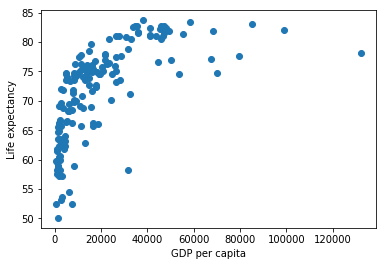

In [10]:
plt.scatter(x_values,y_values)
plt.xlabel('GDP per capita')
plt.ylabel('Life expectancy')
plt.show()

This result wasn't actually what I supposed it would be first, but it makes sense. This is called diminishing returns in economics.
We can see that this is a logarithmic curve.

Because of this, we will take the log of x, so we can perform linear regression. 
Then, we will convert it back to the original form. The line of best fit will also be converted back, so we can predict life expectancy given a GDP per capita data.

In [11]:
for i in range(len(x_values)):
    x_values[i] = np.log(x_values[i])

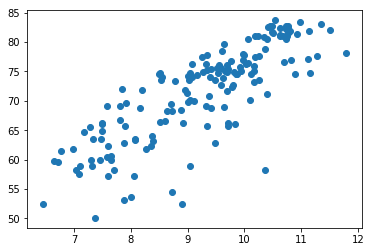

In [12]:
plt.scatter(x_values,y_values)
plt.show()

^ That is the plot of the data, with log(x_values) instead of just x_values.
We train the linear regression model

In [13]:
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(x_values,y_values, test_size=0.25, random_state=9)

In [14]:
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)

y_train =np.array(y_train).reshape(-1,1)
y_test =np.array(y_test).reshape(-1,1)

In [15]:
lm = linear_model.LinearRegression()
lm.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))
#Fitted!
pred_train = lm.predict(x_train)
pred_test = lm.predict(x_test)
print('MSE for training and test data: ')
print(np.mean(y_train-pred_train))
print(np.mean(y_test - pred_test))


MSE for training and test data: 
6.20219506638e-15
-0.355796141605


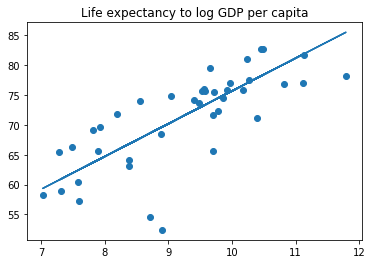

In [16]:
plt.title('Life expectancy to log GDP per capita')
plt.scatter(x_test, y_test)
plt.plot(x_test,pred_test)
plt.show()

Now we will turn this into the original, logarithmic growth function. We now use the full dataset.

In [17]:
for i in range(len(x_values)-1):
    x_values[i] = np.exp(x_values[i])

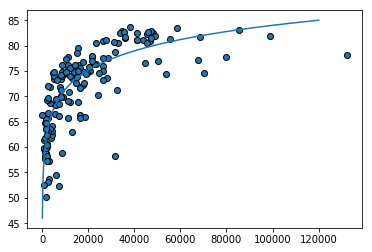

In [18]:
x_values = np.array(x_values).reshape(-1,1)
y_values = np.array(y_values).reshape(-1,1)

plt.scatter(x_values,y_values, edgecolors ='k')
#Declare foo, to take all the possible values of prediction and joining them.
foo = [x for x in range(100, 120000)]
foo = np.array(foo).reshape(-1,1)

plt.plot(foo, lm.predict(np.log(foo.reshape(-1,1))))
plt.show()

Further tuning of the model is possible. The rightmost datapoints are off from the prediction.

This concludes the analysis.